# Try guided autoencoder

In [1]:
import os
import colorcet as cc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR, LinearLR
from toolz import keyfilter, valmap
from torchmetrics.functional import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import warnings

from matplotlib import animation
from ipywidgets import Video
from aging.plotting import PlotConfig, format_pizza_plots, LONGTOGENY_AGE_CMAP
from itertools import product

In [2]:
format_pizza_plots()

In [3]:
warnings.simplefilter('ignore')

In [4]:
def zscore(ser):
    return (ser - ser.mean()) / ser.std()

In [5]:
def plot_embedding(cb: "PlottingCallback", index):
    emb = cb.points[index].T
    fig = plt.figure(figsize=(1.5, 1.5))
    ax = fig.gca()
    enc = LabelEncoder().fit_transform(cb.data.index.get_level_values("sex"))
    mice = np.unique(enc)
    age = cb.data.index.get_level_values("age").to_numpy()
    cmaps = {k: sns.blend_palette(["#333", cc.glasbey[k]], as_cmap=True) for k in mice}
    for k, v in cmaps.items():
        mask = enc == k
        ax.scatter(*emb[:, mask], c=age[mask], cmap=v, s=5, linewidths=0.05, edgecolors='silver', norm='log')
        # ax.scatter(*emb[:, mask], c=age[mask], cmap=v, s=4, norm="log")
    min_x, min_y = np.min(emb, axis=1)
    max_x, max_y = np.max(emb, axis=1)
    y_range = (max_y - min_y) * 0.02
    x_range = (max_x - min_x) * 0.02
    ax.set(
        xlim=(min_x - x_range, max_x + x_range),
        ylim=(min_y - y_range, max_y + x_range),
        xticks=[],
        yticks=[],
    )
    sns.despine(left=True, bottom=True)
    return fig

## Load longtogeny

In [6]:
## update data
def filter_df(df):
    max=39
    n=16
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    df = df.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [7]:
##load male
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
data_all['sex'] = 'm'
data_all.set_index('sex',inplace=True,append=True)
# choose 16 mice from all dataset
n=16
mdata = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)

In [8]:
## load female

In [9]:
##load female
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
data_all['sex'] = 'f'
data_all.set_index('sex',inplace=True,append=True)
# choose 16 mice from all dataset
n=16
fdata = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)

In [10]:
# filter data to make sure only ages from both dataset appear in subsequent analysis
mask = mdata.index.get_level_values('age').intersection(fdata.index.get_level_values('age'))
fdata = fdata[fdata.index.get_level_values('age').isin(mask)]
mdata = mdata[mdata.index.get_level_values('age').isin(mask)]
df=pd.concat([mdata,fdata])

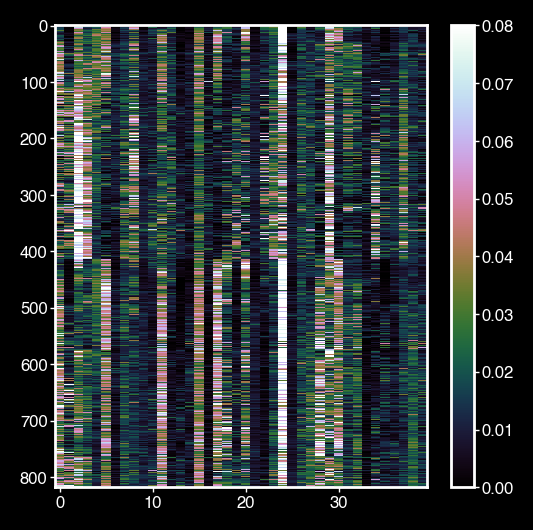

In [11]:
plt.imshow(df, aspect='auto', interpolation='none', vmax=0.08, cmap='cubehelix')
plt.colorbar()

In [12]:
class GuidedAE(nn.Module):
    def __init__(
        self,
        input_dims,
        activation,
        hidden_dims: list | tuple,
        latent_dim,
        mdl_type="regressor",
        n_classes=None,
    ):
        super().__init__()
        self.input_dims = input_dims
        self.n_layers = len(hidden_dims)
        self.hidden_dim = hidden_dims
        self.latent_dim = latent_dim
        if n_classes is None:
            n_classes = latent_dim

        layers = []
        for _in, _out in zip(hidden_dims, hidden_dims[1:]):
            layers.append(nn.Linear(_in, _out))
            layers.append(nn.BatchNorm1d(_out))
            layers.append(activation())

        self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims[0]),
            activation(),
            *layers,
            nn.Linear(hidden_dims[-1], latent_dim),
            # activation(),
        )

        layers = []
        for _in, _out in zip(hidden_dims[::-1], hidden_dims[::-1][1:]):
            layers.append(nn.Linear(_in, _out))
            layers.append(nn.BatchNorm1d(_out))
            layers.append(activation())

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[-1]),
            activation(),
            *layers,
            nn.Linear(hidden_dims[0], input_dims),
        )
        # linear regressor to predict age
        if mdl_type == "regressor":
            self.lm = nn.Linear(latent_dim, 1)
        else:
            self.lm = nn.Linear(latent_dim, n_classes)

    def forward(self, x):
        latent = self.transform(x)
        return self.decoder(latent), self.lm(latent), latent

    def transform(self, x):
        return self.encoder(x)

    def predict(self, x):
        return self.lm(self.transform(x))

In [13]:
class AgeDataset(Dataset):
    def __init__(self, data: pd.DataFrame, log_xform: bool = False):
        self.age = data.index.get_level_values("age")
        self.syllables = data.to_numpy()
        if log_xform:
            self.syllables = np.log(self.syllables + 1e-6)

    def __len__(self):
        return len(self.age)

    def __getitem__(self, idx):
        return torch.tensor(self.syllables[idx], dtype=torch.float), torch.tensor(
            self.age[idx], dtype=torch.float
        )


class MouseDataset(Dataset):
    def __init__(self, data: pd.DataFrame, log_xform: bool = False):
        self.mouse = data.index.get_level_values("age")
        self.mouse = LabelEncoder().fit_transform(self.mouse)
        self.syllables = data.to_numpy()
        if log_xform:
            self.syllables = np.log(self.syllables + 1e-6)

    def __len__(self):
        return len(self.mouse)

    def __getitem__(self, idx):
        return torch.tensor(self.syllables[idx], dtype=torch.float), torch.tensor(
            self.mouse[idx], dtype=torch.long
        )

In [14]:
def lr_func(epoch):
    if epoch < 30:
        return 1
    if epoch < 300:
        return 0.5
    return 0.1

In [15]:
class LitGAE(pl.LightningModule):
    def __init__(
        self,
        model,
        beta,
        data,
        batch_size=32,
        mdl_type="regressor",
        alpha=1e-4,
        lr=1e-3,
    ):
        super().__init__()
        self.model = model
        self.beta = beta
        self.data = data
        self.batch_size = batch_size
        self.mdl_type = mdl_type
        self.alpha = alpha
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        syllables, age = batch
        syllables_hat, age_hat, latent = self.model(syllables)
        loss = self.beta * F.mse_loss(syllables_hat, syllables)
        if self.mdl_type == "classifier":
            loss += (1 - self.beta) * F.cross_entropy(
                age_hat, age
            ) + self.alpha * torch.mean(torch.linalg.norm(latent, dim=1))
        else:
            loss += (1 - self.beta) * F.mse_loss(age_hat.squeeze(), age)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        syllables, age = batch
        syllables_hat, age_hat, _ = self.model(syllables)
        loss = self.beta * F.mse_loss(syllables_hat, syllables)
        if self.mdl_type == "classifier":
            loss += (1 - self.beta) * F.cross_entropy(age_hat, age)
        else:
            loss += (1 - self.beta) * F.mse_loss(age_hat.squeeze(), age)
        self.log("val_loss", loss, prog_bar=True)
        if self.mdl_type == "classifier":
            self.log("acc", age_hat.argmax(dim=1).eq(age).float().mean(), prog_bar=True)
        else:
            self.log("r2", r2_score(age_hat, age.unsqueeze(1)), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-6)
        sched = LinearLR(opt, start_factor=1, end_factor=0.1, total_iters=400)
        return dict(optimizer=opt, lr_scheduler=sched)

    def setup(self, stage):
        kfold = StratifiedKFold(5)
        ex = self.data.sample(frac=1.0, random_state=0)
        #bins = pd.qcut(ex.index.get_level_values("age"), 15, labels=False)
        bins = pd.qcut(ex.index.get_level_values("age"), 1, labels=False)
        for i, (train, test) in enumerate(kfold.split(ex, bins)):
            break
        # train_d = ex.iloc[train]
        train_d = ex
        test_d = ex.iloc[test]
        if self.mdl_type == "classifier":
            self.training_data = MouseDataset(train_d, log_xform=False)
            self.val_data = MouseDataset(test_d, log_xform=False)
        else:
            self.training_data = AgeDataset(train_d, log_xform=False)
            self.val_data = AgeDataset(test_d, log_xform=False)

    def train_dataloader(self):
        return DataLoader(
            self.training_data,
            batch_size=self.batch_size,
            num_workers=int(os.environ.get("SLURM_CPUS_PER_TASK", default=1)),
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            num_workers=int(os.environ.get("SLURM_CPUS_PER_TASK", default=1)),
            shuffle=False,
        )

In [16]:
class PlottingCallback(pl.Callback):
    def __init__(self, data, n_epochs=2):
        super().__init__()
        self.data = data
        self.points = []
        self.n_epochs = n_epochs

    def on_train_epoch_end(self, trainer: pl.Trainer, pl_module):
        if trainer.current_epoch % self.n_epochs == 0:

            emb = (
                model.transform(torch.tensor(self.data.to_numpy(), dtype=torch.float32))
                .detach()
                .numpy()
            )
            self.points.append(emb)


class MetricsAgg(pl.Callback):

    def __init__(self):
        super().__init__()
        self.data = []

    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module):
        d = keyfilter(lambda k: k in ['acc', 'train_loss'], trainer.callback_metrics)
        d = valmap(lambda d: d.item(), d)
        d['epoch'] = trainer.current_epoch
        self.data.append(d)

In [17]:
# in_df = np.log(df[df.index.get_level_values('age') < 750] + 1e-6)
in_df = df[df.index.get_level_values('age') < 100]
in_df = in_df.transform(zscore, axis=1)

# in_df.index = in_df.index.set_levels(
#     zscore(pd.Series(in_df.index.levels[0])), level="age"
# )
in_df = in_df.iloc[:, :40]

In [25]:
in_df

5         11  \
age uuid                                 data sex                       
3   8a69a400-d4c6-4e3a-a1ce-90fd44e2b211 dana m    0.100909 -0.920743   
    e953b275-d126-4a37-888a-7df0af565c0a dana m    0.333069 -0.832280   
    1cd99d3b-cf22-4b80-b97a-bfd3bcff088d dana m   -0.242717 -0.747627   
    183c7534-404c-4071-9b7f-7285d7459409 dana m   -0.560001 -0.713164   
    d046042a-7ce2-4c98-9eb7-888144f3dba9 dana m   -0.260945 -0.864287   
...                                                     ...       ...   
90  f3556a79-f674-4eb5-ae4f-6c8576c0bb9b min  f    1.725912 -0.080573   
    108566e7-1e7e-4847-8917-2f5c130e582c min  f    2.869090  0.698620   
    ffc82238-45c2-452a-895a-c35f174e337b min  f    2.587467  3.062503   
    4d894660-a901-45e4-826c-db79b35a648f min  f    1.132199 -0.104999   
    1f7d9180-9400-4328-b7ca-501f8eaeb644 min  f    0.354602  1.783466   

                                                         0         3   \
age uuid                                 data sex                       
3   8a69a400-d4c6-4e3a-a1ce-90fd44e2b211 dana m    1.809246 -0.384795   
    e953b275-d126-4a37-888a-7df0af565c0a dana m    1.907866  0.159842   
    1cd99d3b-cf22-4b80-b97a-bfd3bcff088d dana m    0.896936 -0.069605   
    183c7534-404c-4071-9b7f-7285d7459409 dana m    0.486611 -0.138804   
    d046042a-7ce2-4c98-9eb7-888144f3dba9 dana m    2.061921 -0.276029   
...                                                     ...       ...   
90  f3556a79-f674-4eb5-ae4f-6c8576c0bb9b min  f    0.802141  0.001540   
    108566e7-1e7e-4847-8917-2f5c130e582c min  f    1.286456  1.399501   
    ffc82238-45c2-452a-895a-c35f174e337b min  f    0.212282 -0.025236   
    4d894660-a901-45e4-826c-db79b35a648f min  f    0.953131  0.253137   
    1f7d9180-9400-4328-b7ca-501f8eaeb644 min  f    2.619874  0.476578   

                                                         12        20  \
age uuid                                 data sex                       
3   8a69a400-d4c6-4e3a-a1ce-90fd44e2b211 dana m   -0.368046  0.888084   
    e953b275-d126-4a37-888a-7df0af565c0a dana m    0.301574  0.600785   
    1cd99d3b-cf22-4b80-b97a-bfd3bcff088d dana m    0.204488  0.550712   
    183c7534-404c-4071-9b7f-7285d7459409 dana m    0.269630  0.627010   
    d046042a-7ce2-4c98-9eb7-888144f3dba9 dana m   -0.019609  1.352994   
...                                                     ...       ...   
90  f3556a79-f674-4eb5-ae4f-6c8576c0bb9b min  f   -0.881175  1.089536   
    108566e7-1e7e-4847-8917-2f5c130e582c min  f   -1.064887 -0.047479   
    ffc82238-45c2-452a-895a-c35f174e337b min  f   -0.737792  1.261322   
    4d894660-a901-45e4-826c-db79b35a648f min  f   -0.511972  0.448484   
    1f7d9180-9400-4328-b7ca-501f8eaeb644 min  f    0.197776 -0.133303   

                                                         32        13  \
age uuid                                 data sex                       
3   8a69a400-d4c6-4e3a-a1ce-90fd44e2b211 dana m   -0.887247 -0.317801   
    e953b275-d126-4a37-888a-7df0af565c0a dana m   -0.848028 -0.454329   
    1cd99d3b-cf22-4b80-b97a-bfd3bcff088d dana m   -0.790905 -0.401403   
    183c7534-404c-4071-9b7f-7285d7459409 dana m   -0.662109 -0.470656   
    d046042a-7ce2-4c98-9eb7-888144f3dba9 dana m   -0.879371 -0.291113   
...                                                     ...       ...   
90  f3556a79-f674-4eb5-ae4f-6c8576c0bb9b min  f   -0.963288 -0.244799   
    108566e7-1e7e-4847-8917-2f5c130e582c min  f   -0.590097  0.698620   
    ffc82238-45c2-452a-895a-c35f174e337b min  f   -0.995103 -0.678412   
    4d894660-a901-45e4-826c-db79b35a648f min  f   -0.853830 -0.316625   
    1f7d9180-9400-4328-b7ca-501f8eaeb644 min  f   -1.039411 -0.272704   

                                                         4         33  ...  \
age uuid                                 data sex                      ...   
3   8a69a400-d4c6-4e3a-a1ce-90fd44e2b211 dana m    1.306794 -0.887247  ...   
    e953b275-d126-4a37-

In [18]:
mdl_type = "classifier"
n_mice = in_df.index.get_level_values("sex").nunique()

In [19]:
config = PlotConfig()

In [20]:
(config.save_path / "movies").mkdir(exist_ok=True)

## Fit specific dim size and seed

In [21]:
mdl_type = "classifier"
n_mice = in_df.index.get_level_values("sex").nunique()

In [23]:
n_mice

2

In [22]:
pl.seed_everything(3)
model = GuidedAE(
    len(in_df.columns),
    nn.GELU,
    [75],
    latent_dim=2,
    mdl_type=mdl_type,
    n_classes=n_mice,
)
gae = LitGAE(
    model, 0.5, in_df, batch_size=64, mdl_type=mdl_type, alpha=1e-3, lr=1e-2
)
cb = PlottingCallback(in_df, n_epochs=1)

trainer = pl.Trainer(
    max_epochs=600,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=False,
    precision="16-mixed" if torch.cuda.is_available() else "bf16-mixed",
    enable_checkpointing=False,
    enable_progress_bar=True,
    check_val_every_n_epoch=100,
    callbacks=[cb],
)
trainer.fit(gae)

[rank: 0] Global seed set to 3
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 6.5 K 
-----------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

IndexError: Target 12 is out of bounds.

In [24]:
gae

LitGAE(
  (model): GuidedAE(
    (encoder): Sequential(
      (0): Linear(in_features=40, out_features=75, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=75, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=75, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=75, out_features=40, bias=True)
    )
    (lm): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [ ]:
fig = plot_embedding(cb, -1)

In [ ]:
#saver(fig, "guided-ae-embedding-bw");

In [ ]:
points = np.array(cb.points)

In [ ]:
points.shape

In [ ]:
x_points = pd.DataFrame(points[..., 0])
x_points = (
    x_points.rolling(window=7, center=True, win_type="gaussian").mean(std=1.5).dropna()
)

y_points = pd.DataFrame(points[..., 1])
y_points = (
    y_points.rolling(window=7, center=True, win_type="gaussian").mean(std=1.5).dropna()
)

In [ ]:
points = np.stack((x_points, y_points), axis=-1)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))
enc = LabelEncoder().fit_transform(cb.data.index.get_level_values("sex"))
emb = points[0].T
scat1 = ax[0].scatter(*emb, c=enc, cmap=cc.cm.glasbey, s=3)
scat2 = ax[1].scatter(
    *emb, c=cb.data.index.get_level_values("age"), s=3, cmap=LONGTOGENY_AGE_CMAP
)
min_x, min_y = np.min(emb, axis=1)
max_x, max_y = np.max(emb, axis=1)
y_range = (max_y - min_y) * 0.02
x_range = (max_x - min_x) * 0.02
for a in ax:
    a.set(
        xlim=(min_x - x_range, max_x + x_range),
        ylim=(min_y - y_range, max_y + x_range),
        xticks=[],
        yticks=[],
    )
sns.despine(left=True, bottom=True)


def update(frame):
    emb = frame.T
    min_x, min_y = np.min(emb, axis=1)
    max_x, max_y = np.max(emb, axis=1)
    y_range = (max_y - min_y) * 0.02
    x_range = (max_x - min_x) * 0.02
    scat1.set_offsets(emb.T)
    scat2.set_offsets(emb.T)
    for a in ax:
        a.set(
            xlim=(min_x - x_range, max_x + x_range),
            ylim=(min_y - y_range, max_y + x_range),
        )
    return scat1, scat2


ani = animation.FuncAnimation(
    fig=fig, func=update, frames=points, blit=True, interval=0
)
ani.save(
    filename=config.save_path / "movies" / "guided-ae-2plot-talk.mp4",
    writer="ffmpeg",
    fps=45,
)

In [ ]:
Video.from_file(config.save_path / "movies" / "guided-ae-2plot-talk.mp4")

In [ ]:
misc = folder / "misc"
misc.mkdir(exist_ok=True)

In [ ]:
torch.save(gae.model, misc / "guided_ae_params.pt")

In [ ]:
import joblib

In [ ]:
joblib.dump(
    dict(
        emb=cb.points[-1], age=cb.data.index.get_level_values("pseudo_age"), mouse=enc
    ),
    misc / "embedding.p",
)